In [3]:
import torch
import argparse
import os
import numpy as np

# TensorBoard
from torch.utils.tensorboard import SummaryWriter

from data import get_dataset
from experiment import ex
from model import load_model

from utils import post_config_hook
from utils.yaml_config_hook import yaml_config_hook
from utils.eval import eval_all
from utils.youtube import download_yt
from datasets.utils.resample import convert_samplerate

import matplotlib.pyplot as plt


cfg = yaml_config_hook("./config/config.yaml")

args = argparse.Namespace(**cfg)
args.dataset = "magnatagatune"
args.model_path = "/storage/jspijkervet/logs_backup_ws7/clmr/2/"
args.epoch_num= 1490
args.finetune_model_path = "/storage/jspijkervet/logs_backup_ws7/clmr/4"
args.finetune_epoch_num = 50
args.n_classes = 50 # 50 tags

/home/jspijkervet/miniconda3/envs/clmr/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/jspijkervet/miniconda3/envs/clmr/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [4]:
args.lin_eval = True
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
args.batch_size = args.logistic_batch_size

In [5]:
(train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset) = get_dataset(args)

### Linear / Supervised training, using segmented dataset ###
Num segments: 187060
Num tracks: 18706
/storage/jspijkervet/magnatagatune/statistics_segments_22050.csv
[Train dataset (magnatagatune_segments_22050)]: Loaded mean/std: -7.70555e-05, 0.17842068
### Linear / Supervised training, using segmented dataset ###
Num segments: 18250
Num tracks: 1825
/storage/jspijkervet/magnatagatune/statistics_segments_22050.csv
[Validation dataset (magnatagatune_segments_22050)]: Loaded mean/std: -7.70555e-05, 0.17842068
### Linear / Supervised training, using segmented dataset ###
Num segments: 53290
Num tracks: 5329
/storage/jspijkervet/magnatagatune/statistics_segments_22050.csv
[Test dataset (magnatagatune_segments_22050)]: Loaded mean/std: -7.70555e-05, 0.17842068


In [6]:
context_model, _, _ = load_model(args, reload_model=True, name=args.model_name)
context_model.eval()

args.n_features = context_model.n_features

model, _, _ = load_model(args, reload_model=True, name="supervised")
model = model.to(args.device)

print(context_model)
print(model)

### SampleCNN59049 ###
### RELOADING CLMR MODEL FROM CHECKPOINT 1490 ###
### Using Adam optimizer ###
### RELOADING CLMR OPTIMIZER FROM CHECKPOINT 1490 ###
### RELOADING SUPERVISED MODEL FROM CHECKPOINT 50 ###
### Using Adam optimizer ###
### RELOADING SUPERVISED OPTIMIZER FROM CHECKPOINT 50 ###
CLMR(
  (encoder): SampleCNN59049(
    (conv1): Sequential(
      (0): Conv1d(1, 128, kernel_size=(3,), stride=(3,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_

[youtube] 4Tr0otuiQuU: Downloading webpage
[download] yt.mp3 has already been downloaded
[download] 100% of 15.46MiB
[ffmpeg] Post-process file yt.mp3 exists, skipping


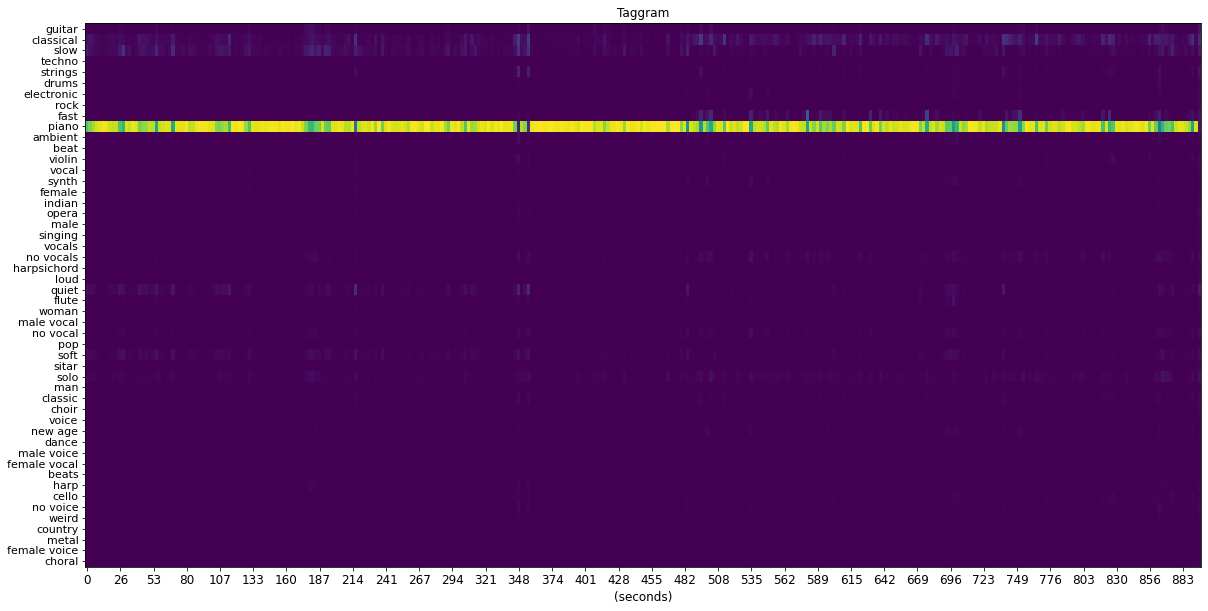

In [7]:
args.audio_url = "https://www.youtube.com/watch?v=4Tr0otuiQuU"
tmp_input_file = "yt.mp3"
args.current_epoch = 0

download_yt(args.audio_url, tmp_input_file, args.sample_rate)

conv_fn = f"{tmp_input_file}_{args.sample_rate}"
convert_samplerate(tmp_input_file, conv_fn, args.sample_rate)

yt_audio = train_dataset.get_audio(conv_fn)

# to mono
yt_audio = yt_audio.mean(axis=0).reshape(1, -1)

# split into equally sized tensors of args.audio_length
chunks = torch.split(yt_audio, args.audio_length, dim=1)
chunks = chunks[:-1] # remove last one, since it's not a complete segment of audio_length

with torch.no_grad():
    taggram = []
    for idx, x in enumerate(chunks):
        x = x.to(args.device)

        # normalise
        if train_dataset.mean:
            x = train_dataset.normalise_audio(x)

        # add batch dim
        x = x.unsqueeze(0)         
        h, z = context_model(x)

        output = model(h)
        output = torch.nn.functional.softmax(output, dim=1)
        output = output.squeeze(0) # remove batch dim
        taggram.append(output.cpu().detach().numpy())

taggram = np.array(taggram)


## global figure settings
plt.rcParams["figure.figsize"] = (20,10) # set size of the figures
fontsize = 12 # set figures font size
in_length = yt_audio.shape[1] / args.sample_rate

## figure
fig, ax = plt.subplots()
ax.title.set_text('Taggram')
ax.title.set_fontsize(fontsize)
ax.set_xlabel('(seconds)', fontsize=fontsize)

## y-axis
tags = train_dataset.tags
y_pos = np.arange(len(tags))
ax.set_yticks(y_pos)
ax.set_yticklabels(tags, fontsize=fontsize-1)

## x-axis
x_pos = np.arange(0, taggram.shape[0], 10)
ax.set_xticks(x_pos)
x_label = [int(x * (args.audio_length / args.sample_rate)) for x in x_pos]
ax.set_xticklabels(x_label, fontsize=fontsize)


plt.imshow(taggram.T, interpolation=None, aspect="auto")
plt.show()

[('piano', 0.8874337), ('classical', 0.028353192), ('slow', 0.019458722)]


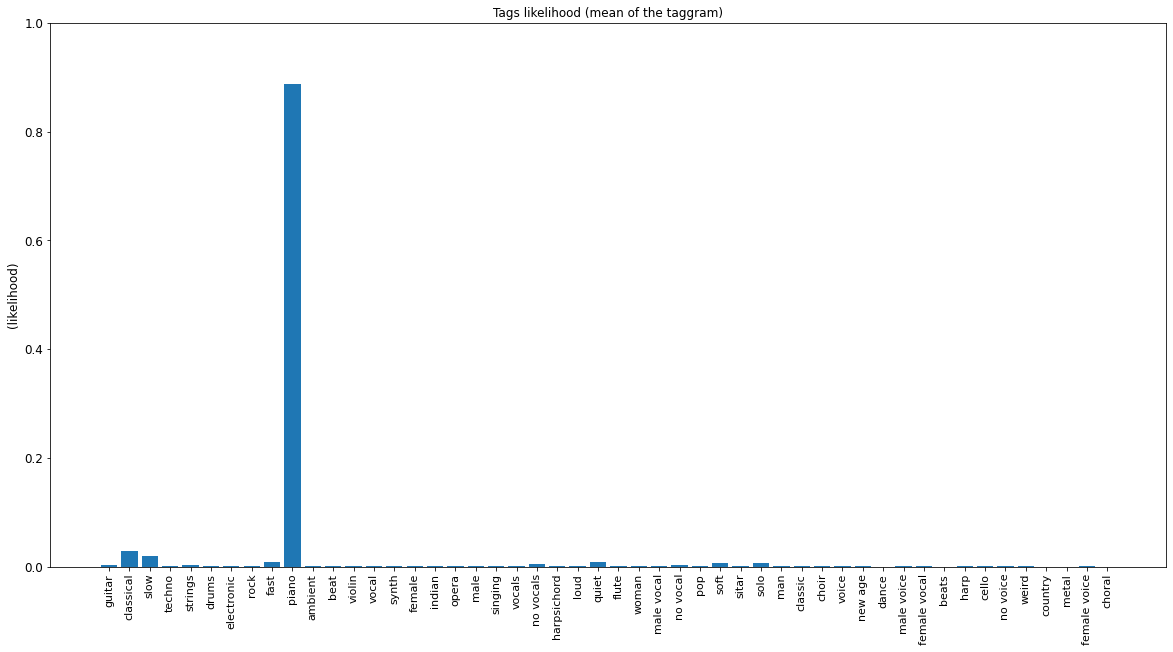

In [8]:
# mean of taggram
fig, ax = plt.subplots()
tags_likelihood_mean = np.mean(taggram, axis=0) # averaging the Taggram through time
# title
ax.title.set_text('Tags likelihood (mean of the taggram)')
ax.title.set_fontsize(fontsize)

# y-axis title
ax.set_ylabel('(likelihood)', fontsize=fontsize)

# y-axis
ax.set_ylim((0, 1))
ax.tick_params(axis="y", labelsize=fontsize)

# x-axis
ax.tick_params(axis="x", labelsize=fontsize-1)
pos = np.arange(len(tags))
ax.set_xticks(pos)
ax.set_xticklabels(tags, rotation=90)

# depict song-level tags likelihood
ax.bar(pos, tags_likelihood_mean)
plt.savefig("inference_likelihood.png")

N = 3
tags_likelihoods = [(t, l) for t, l in zip(tags, tags_likelihood_mean)]
top_N = sorted(tags_likelihoods, key=lambda x: x[1], reverse=True)[:N]
print(top_N)


In [9]:
os.remove(tmp_input_file)
os.remove(conv_fn)